## About

The idea is to create a model that will work on the CIDAR10 dataset and give accuracy of upto 90%, as opposed to the 55% accuracy of CNN models. 

We will use the following techniques:-
1. Data Normalization 
2. Data Augmentation
3. Residual Connections
4. Batch Normalization
5. Learning Rate Annealing
6. Weight Decay
7. Gradient Clipping

## Loading the Data

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
# download data
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,".")

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [3]:
# Uncomment to extract the files

with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
data_dir = "./data/cifar10"
classes = os.listdir(data_dir+"/train")
print(os.listdir(data_dir)) 
print(classes)

['test', 'train']
['ship', 'bird', 'truck', 'automobile', 'deer', 'dog', 'frog', 'airplane', 'cat', 'horse']


## Making PyTorch Dataset

We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<center><img src="https://i.imgur.com/LYxXBVg.png" width="360"></center>


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

## Creating Transformations for training and validation sets

In [6]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# these are the mean and std deviation values for the entire dataset. These need to be calculated, but we have them for now.
train_tfms = tt.Compose([
    tt.RandomCrop(32,padding =4, padding_mode='reflect'), # does step 3. reflect means that the padding wont be black but rather be a reflection of the image
    tt.RandomHorizontalFlip(), # has default probability of 0.5
    # Above 2 transformation are done on python images by default PILs. 
    tt.ToTensor(), # Need to convert to tensors to normalize
    tt.Normalize(*stats) # Normalization by giving stats as parameters for each channel
])

valid_tfms = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

### Getting Mean Stats for Red Channel Process. 

In [7]:
# train_ds = ImageFolder(data_dir+"/train", train_tfms)


In [8]:
# train_dataset = ImageFolder(data_dir+"/train", transform=tt.ToTensor())

In [9]:
# import numpy as np

In [10]:
# r_sum = torch.from_numpy(np.zeros((32,32)))

In [11]:
# for images,labels in train_dataset:
#     r_sum = r_sum+images[0]

In [12]:
# torch.mean(r_sum)

In [13]:
24569.9845/50000 # mean divided by number of elements 

0.49139969

## Applying Transformations according to Transformations created

In [14]:
train_ds = ImageFolder(data_dir+"/train", train_tfms)
valid_ds = ImageFolder(data_dir+"/test", valid_tfms)

## Making DataLoaders

In [15]:
from torch.utils.data import DataLoader

In [16]:
batch_size = 256

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True, num_workers=8, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


num_workers allows us to set how many cpu cores the loader can use. pin_memory allows us to avoid repeated memory allocation and deallocation using same portion of RAM. 

In [17]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
def show_batch(dl):
    for images,labels in dl:
        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:100],10).permute(1,2,0))
        break

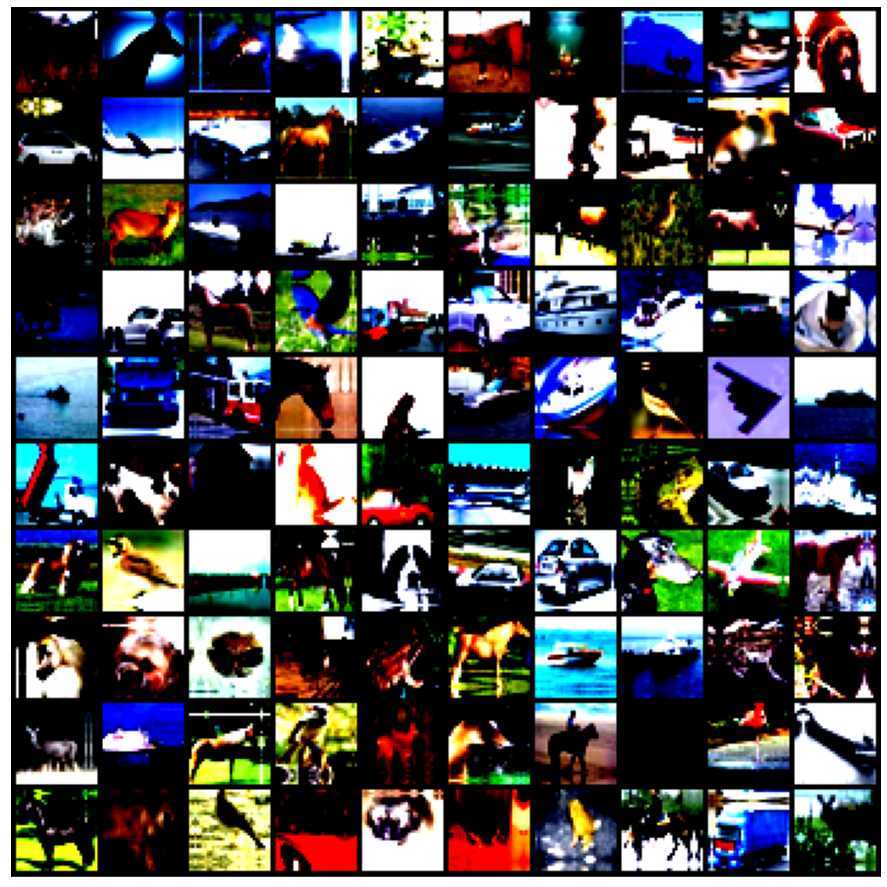

In [19]:
show_batch(train_dl)

Now we see that the images are a bit weird. This is largely due to the normalization that we did on the images. We can further see the images have ben cropped and hae a reflecting padding on them 

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)



Making a simple resnet

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,3,kernel_size=3,stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(3,3,kernel_size=3,stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out+x)

In [22]:
simple_resnet = SimpleResidualBlock()

for images,labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

torch.Size([256, 3, 32, 32])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. 

### Batch Normalization

Even though we have normalized the datasets at the start, it doesnt mean the channels of a batch or after every layer in the model will be normalized. If we have a situation where the normalization changes after a batch, the weights of channels will become incorrect and hence lead to a worse off model. Hence, there is a need to normalize the batch after every layer. 

In Batch Normalization, it by itself stores the means and std devs of the batches and is able to train the model accordingly and is able to normalize the data without input being always provided to it.  

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

A resnet 22 block is like so
![resnet-22](https://miro.medium.com/max/5000/1*gOyiFYGHMAEDlyoAIhkWkA.png)

### Making the model 

In [23]:
def conv_2d(ni,nf,stride = 1, ks=3):
    return nn.Conv2d(in_channels=ni,out_channels=nf,stride=stride,kernel_size=ks, padding=ks//2, bias=False)

In [24]:
def bn_relu_conv(ni,nf):
    return nn.Sequential(
        nn.BatchNorm2d(ni),
        nn.ReLU(inplace=True),
        conv_2d(ni,nf)
    )

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self,ni,nf,stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni,nf,stride)
        self.conv2 = bn_relu_conv(nf,nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni,nf, stride, ks=1)
    
    def forward(self,x):
        x = F.relu(self.bn(x),inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [26]:
# Making groups
def make_groups(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride) # makes the initial residual block where ni != nf (where we need shortcut to be scaled up [basically where we use the 1x1 kernel])
    rest = [ResidualBlock(nf,nf) for j in range(1,N)] # makes the rest of Residual Blocks where ip channel = output channels
    return [start] + rest

In [27]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,x):
        return x.view(x.size(0),-1)

In [28]:
class WideResNet(nn.Module):
    def __init__(self,n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()
        layers = [conv_2d(3,n_start)] # layer before officially entering resnet / a group
        n_channels = [n_start]
        
        for i in range(n_groups):
            n_channels.append(n_start * (2**i) * k) # k is wideness factor. Determines the multiple in which channel should increase in each group
            stride = 2 if i>1 else 1
            layers += make_groups(N, n_channels[i],n_channels[i+1],stride) # adding groups to the layer
        
        layers+=[
            nn.BatchNorm2d(n_channels[3]), # normalizing according to last batch output number of channels
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Linear(n_channels[3],n_classes)            
        ]
        
        self.features = nn.Sequential(*layers) # opening up the layers in a sequence.
        
    def forward(self, x): 
        return self.features(x)
            

In [29]:
def wrn_22():
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

In [30]:
model = wrn_22()

In [31]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [32]:
# Example
for images,labels in train_dl:
    print(images.shape) 
    out = model(images)
    print(out.shape)
    preds = F.softmax(out[0],dim=0)
    _,pred_label = torch.max(preds,dim=0)
    print(pred_label, labels[0])
    break;

torch.Size([256, 3, 32, 32])
torch.Size([256, 10])
tensor(6) tensor(8)


## Training the model

In the previous tutorials, we defined helper functions to train the model. This time, we'll use some functions from the FastAI library, which builds on top of PyTorch and offers many utilities, including a powerful & customizable training loop with learning rate scheduling.

Learning rate scheduling refers to the process of dynamically changing the learning rate while the model is being trained. There are many strategies for changing the learning rate during training, and the one we'll use is called the 1-cycle policy. We start out with a low learning rate, then gradually increase it linearly to high value for about half of the training, and then slowly bring it to the original value. At the end, we train for few iterations with a very low learning rate.

<img src="https://sgugger.github.io/images/art5_lr_schedule.png">

Here's a great explanation of the 1-cycle policy: https://sgugger.github.io/the-1cycle-policy.html

In [33]:
!pip install fastai==1.0.61

     |████████████████████████████████| 239 kB 556 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19191 sha256=7eda84053eff64abe7e7946bf9900babe2dd06612dc365276c5967c76b48363d
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3
  Attempting uninstall: fastai
    Found existing installation: fastai 2.5.3
    Uninstalling fastai-2.5.3:
      Successfully uninstalled fastai-2.5.3


In [34]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

Now we will use Data Bunch to create data loaders in a DataBunch object for the train and validation set from their respective datasets.

We will also be making a Learner object using our DataBunch, loss function and model.

A interesting feature of DataBunch is also that it automatically moves the data to the GPU. The Learner also moves the model to the GPU

In [35]:
data = DataBunch.create(train_ds, valid_ds, bs=batch_size, path="./data/cifar10")
learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
learner_clip = 0.1

The statement `learner.clip = 0.1` is used to perform gradient clipping i.e. it limits the values of gradients to the range `[-1,1]`, thus preventing the undesirable changes in the parameters (weights & biases) due to large gradient values.

FastAI also provides a helpful learning rate finder, which tries a range of learning rates, and helps you select a good learning rate by looking at the graph of loss vs. learning rate.

In [36]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


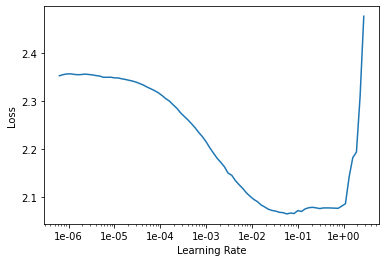

In [37]:
learner.recorder.plot()

As we can see from the graph above, the loss started to decrease starkly around 5e-3 so that should be our lr

### Training the Data
We finally train the data by using the `.fit_one_cycle` function of fastai. <br>
We give it epochs and the learning rate, along with that, we give it a special value called weight decay. 

Weight decay - It adds a certain value to the loss function to prevent the weights from becoming too large. It is a regularization technique. 


In [38]:
learner.fit_one_cycle(9,5e-3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.302235,1.435738,0.525400,03:03
1,1.023451,1.513357,0.466300,03:03
2,0.833277,1.397322,0.617400,03:03
3,0.665109,0.927497,0.715400,03:03
4,0.534810,0.705221,0.776300,03:03
5,0.423996,0.494336,0.836000,03:03
6,0.330734,0.359000,0.877700,03:03
7,0.242490,0.316967,0.896000,03:03
8,0.206578,0.305636,0.900400,03:03


As you can see, the model quickly reaches an accuracy of over 90% in just 9 epochs. It is quite a feat, considering that our simple CNN model struggled to reach 60% accuracy even after training for a long time.

In fact, if we continue to train this model for longer, it will soon reach an accuracy of around 95%, which is quite close to the state of the art. The model and techniques covered in this tutorial were actually used by the FastAI team for their submission to the Stanform DawnBench competition.


## Plotting Losses and Metrics

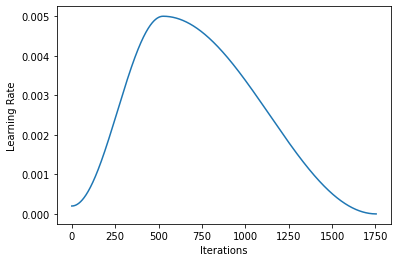

In [39]:
learner.recorder.plot_lr()


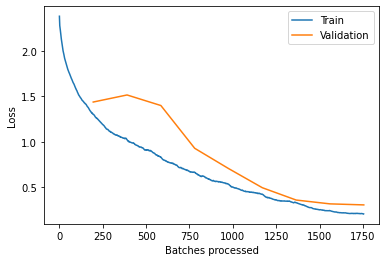

In [40]:
learner.recorder.plot_losses()


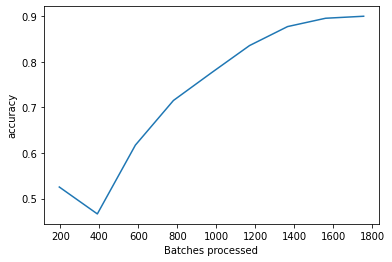

In [41]:
learner.recorder.plot_metrics()
